###Autoencoders
#####This Project demonstrates the implementation of different types of Autoencoders
Autoencoders are a specific type of feedforward neural networks where the input is the same as the output.
They compress the input into a lower-dimensional code and then reconstruct the output from this representation. 
The code is a compact “summary” or “compression” of the input, also called the latent-space representation.
Autoencoders are an unsupervised learning technique which consists of 3 components:"Encoder, Code, Decoder"
The encoder compresses the input and produces the code, the decoder then reconstructs the input only using this code.

4 types of autoencoders are described in this project using the **PyTorch** framework and the **MNIST** dataset

1. Vanilla autoencoders
2. Multilayer autoencoder
3. Convolutional autoencoder
4. Denoising autoencoder

In [1]:
#Import Libraries
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

In [3]:
#Load the Data and convert data into tensors which is 3 dimensional(RGB)
transform=transforms.ToTensor()

train_data=datasets.MNIST(root='data',train=True,download=True,transform=transform)
test_data=datasets.MNIST(root='data',train=False,download=True,transform=transform)

In [4]:
# Create training and test dataloaders
num_workers=0
batch_size=20
train_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,num_workers=num_workers)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)


###Visualize the Data

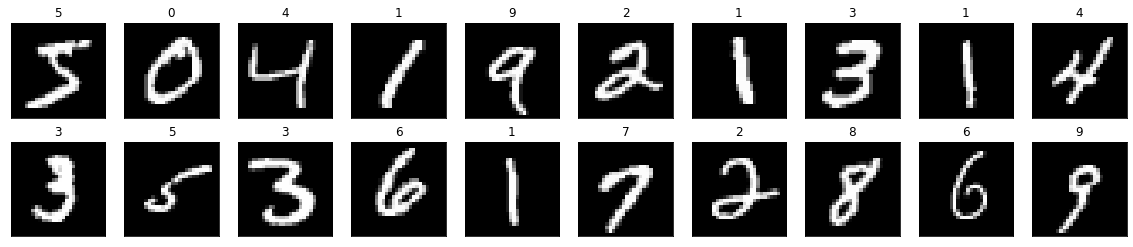

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter=iter(train_loader)
images,labels=dataiter.next()
images=images.numpy()

fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))


In [6]:
print(images.shape)
print(labels.shape)
print(len(train_loader))

(20, 1, 28, 28)
torch.Size([20])
3000


###**Vanilla** **Autoencoder**
We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building a simple autoencoder. The encoder and decoder should be made of one linear layer. The units that connect the encoder and decoder will be the compressed representation and this representation is a vector with dimension
encoding_dim=32
####The first network is the most simple autoencoder. It has three layers : Input - encoded - decoded i.e; **784 inputs > encoding_dim > 784 outputs**. All layers will have ReLu activations applied except for the final output layer, which has a sigmoid activation.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class VanillaAutoencoder(nn.Module):
  def __init__(self,encoding_dim):
    super(VanillaAutoencoder,self).__init__()
    #encoder
    self.fc1=nn.Linear(28*28,encoding_dim)
    #decoder
    self.fc2=nn.Linear(encoding_dim,28*28)

  def forward(self,x):
    x=F.relu(self.fc1(x))
    # output layer (sigmoid for scaling from 0 to 1)
    x=F.sigmoid(self.fc2(x))

    return x

encoding_dim=32
vanilla_model=VanillaAutoencoder(encoding_dim)
print(vanilla_model)

VanillaAutoencoder(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
)


###Training
I have used **MSELoss**. And compare output images and input images as follows:

loss = criterion(outputs, images)
and **Adam** optimizer to optimize parameters

In [8]:
criterion=nn.MSELoss()

optimizer=torch.optim.Adam(vanilla_model.parameters(),lr=0.001)

In [9]:
n_epochs=20

for epoch in range(1,n_epochs+1):
  #monitor training loss
  train_loss=0.0
  for data in train_loader:
    images,_ = data
    #flatten images to get the dimesion as [batch_size,784]
    images=images.view(images.size(0),-1)
    #Forward pass
    optimizer.zero_grad()
    outputs=vanilla_model(images)
    loss=criterion(outputs,images)
    #Backward pass
    loss.backward()
    optimizer.step()
    # update running training loss
    train_loss+=loss.item()*images.size(0)

  train_loss=train_loss/len(train_loader)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch,train_loss))
   
  

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.634173
Epoch: 2 	Training Loss: 0.321965
Epoch: 3 	Training Loss: 0.283522
Epoch: 4 	Training Loss: 0.274732
Epoch: 5 	Training Loss: 0.271152
Epoch: 6 	Training Loss: 0.268722
Epoch: 7 	Training Loss: 0.267099
Epoch: 8 	Training Loss: 0.265996
Epoch: 9 	Training Loss: 0.265126
Epoch: 10 	Training Loss: 0.264407
Epoch: 11 	Training Loss: 0.263620
Epoch: 12 	Training Loss: 0.262592
Epoch: 13 	Training Loss: 0.262044
Epoch: 14 	Training Loss: 0.261570
Epoch: 15 	Training Loss: 0.261053
Epoch: 16 	Training Loss: 0.260612
Epoch: 17 	Training Loss: 0.260222
Epoch: 18 	Training Loss: 0.259816
Epoch: 19 	Training Loss: 0.259465
Epoch: 20 	Training Loss: 0.259130


###Visualization
Prediction on the Test set
Below I've plotted some of the test images along with their reconstructions. 
They are indeed pretty similar, but not exactly the same. We can notice it more clearly in the digit **9**. 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


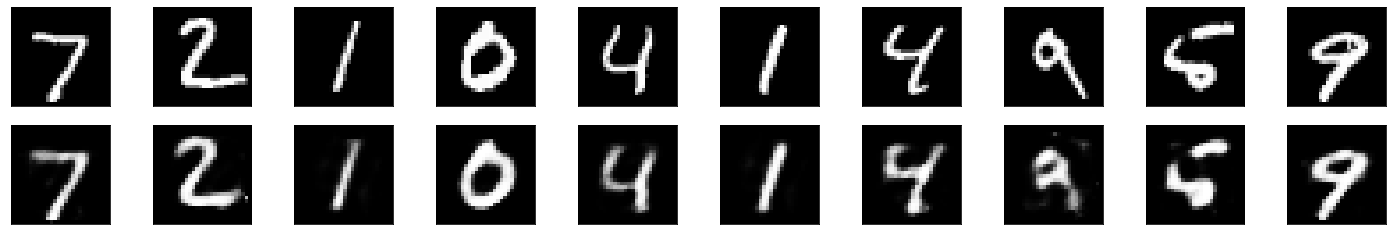

In [10]:
dataiter=iter(test_loader)
images,_ = dataiter.next()
images_flatten=images.view(images.size(0),-1)
output=vanilla_model(images_flatten)
images=images.numpy()

output=output.view(batch_size,1,28,28)
output=output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


###Multilayer autoencoder
We extend the idea of the first network to more layers. It has five layers : 784 inputs > encoding_dim >code_size>encoding_dim> 784 outputs. All layers will have ReLu activations applied except for the final output layer, which has a sigmoid activation.

In [15]:
class MultilayerAutoencoder(nn.Module):
  def __init__(self,encoding_dim,code_size):
    super(MultilayerAutoencoder,self).__init__()

    #Encoder
    self.fc1=nn.Linear(28*28,encoding_dim)
    self.fc2=nn.Linear(encoding_dim,code_size)
    #Decoder
    self.fc3=nn.Linear(code_size,encoding_dim)
    self.fc4=nn.Linear(encoding_dim,28*28)

  def forward(self,x):
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=F.relu(self.fc3(x))
    x=F.sigmoid(self.fc4(x))

    return x
encoding_dim=128
code_size=64
multilayer_model=MultilayerAutoencoder(encoding_dim,code_size)
print(multilayer_model)



MultilayerAutoencoder(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
)


###Training
1. Loss=MSELoss
2. optimizer=Adam
3. lr=0.001

In [16]:
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(multilayer_model.parameters(),lr=0.001)

In [17]:
n_epochs=20
train_loss1=[]
for epoch in range(1,n_epochs+1):
  train_loss=0.0
  for data in train_loader:
    images,_ = data
    images=images.view(images.size(0),-1)

    optimizer.zero_grad()
    outputs=multilayer_model(images)
    loss=criterion(outputs,images)
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()*images.size(0)
    train_loss1.append(train_loss)
  train_loss=train_loss/len(train_loader)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch,train_loss))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.509156
Epoch: 2 	Training Loss: 0.218884
Epoch: 3 	Training Loss: 0.174337
Epoch: 4 	Training Loss: 0.148271
Epoch: 5 	Training Loss: 0.132531
Epoch: 6 	Training Loss: 0.122448
Epoch: 7 	Training Loss: 0.114384
Epoch: 8 	Training Loss: 0.107842
Epoch: 9 	Training Loss: 0.102828
Epoch: 10 	Training Loss: 0.098733
Epoch: 11 	Training Loss: 0.095757
Epoch: 12 	Training Loss: 0.093556
Epoch: 13 	Training Loss: 0.091890
Epoch: 14 	Training Loss: 0.090546
Epoch: 15 	Training Loss: 0.089475
Epoch: 16 	Training Loss: 0.088575
Epoch: 17 	Training Loss: 0.087810
Epoch: 18 	Training Loss: 0.087141
Epoch: 19 	Training Loss: 0.086521
Epoch: 20 	Training Loss: 0.085948


###plot the model loss

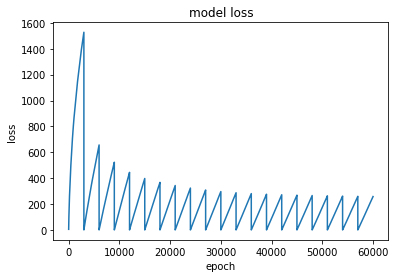

In [25]:
plt.title('model loss')
plt.plot(train_loss1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

###Prediction on test set

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


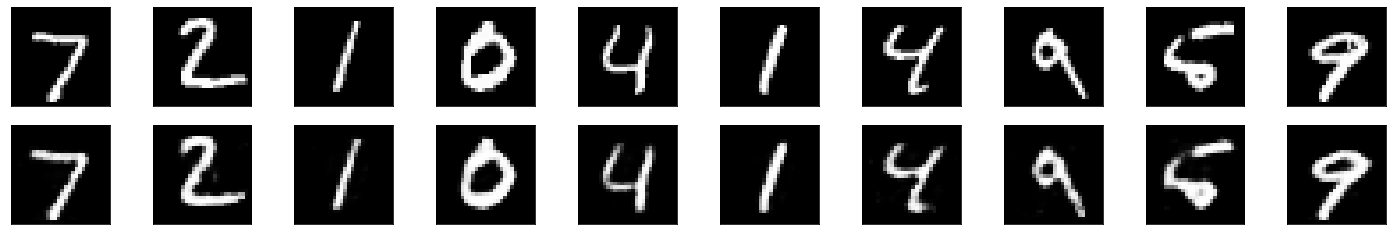

In [18]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)

output = multilayer_model(images_flatten)
images = images.numpy()


output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

###Convolutional Autoencoder
####Encoder
The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers.

####Decoder
The decoder needs to convert from a narrow representation to a wide, reconstructed image. For example, the representation could be a 7x7x4 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the compressed representation.

####Conclusion
Here our final encoder layer has size 7x7x4 = 196. The original images have size 28x28 = 784, so the encoded vector is 25% the size of the original image.

In [20]:
class ConvAutoencoder(nn.Module):
  def __init__(self):
    super(ConvAutoencoder,self).__init__()
    #encoder layers
    # conv layer (depth from 1 --> 16), 3x3 kernels
    self.conv1=nn.Conv2d(1,16,3,padding=1)
    # conv layer (depth from 16 --> 4), 3x3 kernels
    self.conv2=nn.Conv2d(16,4,3,padding=1)
    # pooling layer to reduce x-y dims by two; kernel and stride of 2
    self.pool=nn.MaxPool2d(2,2)
    #decoder layers
    #a kernel of 2 and a stride of 2 will increase the spatial dims by 2
    self.t_conv1=nn.ConvTranspose2d(4,16,2,stride=2)
    self.t_conv2=nn.ConvTranspose2d(16,1,2,stride=2)

  def forward(self,x):
    #encode
    x=F.relu(self.conv1(x))
    x=self.pool(x)

    x=F.relu(self.conv2(x))
    x=self.pool(x)      # compressed representation
    #decode
    x=F.relu(self.t_conv1(x))
    x=F.sigmoid(self.t_conv2(x))

    return x
conv_model=ConvAutoencoder()
print(conv_model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


###Training
1. Loss = MSELoss
2. optimizer = Adam
3. lr = 0.001
Since this is a convlutional autoencoder, our images do not need to be flattened before being passed in an input to our model.

In [21]:
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)

In [ ]:
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = conv_model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.576866
Epoch: 2 	Training Loss: 0.246045
Epoch: 3 	Training Loss: 0.211998
Epoch: 4 	Training Loss: 0.198732
Epoch: 5 	Training Loss: 0.191192
Epoch: 6 	Training Loss: 0.186111
Epoch: 7 	Training Loss: 0.182125
Epoch: 8 	Training Loss: 0.178682
Epoch: 9 	Training Loss: 0.175747
Epoch: 10 	Training Loss: 0.173001
Epoch: 11 	Training Loss: 0.170806
Epoch: 12 	Training Loss: 0.169189
Epoch: 13 	Training Loss: 0.167964
Epoch: 14 	Training Loss: 0.166961
Epoch: 15 	Training Loss: 0.166111
Epoch: 16 	Training Loss: 0.165283
Epoch: 17 	Training Loss: 0.164390
Epoch: 18 	Training Loss: 0.163626
Epoch: 19 	Training Loss: 0.162932


###Visualization

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


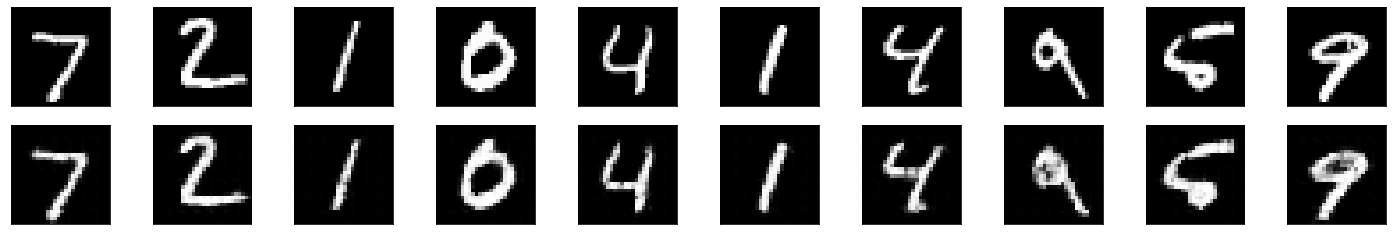

In [23]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

output = conv_model(images)
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

###Denoising Autoencoder
Sticking with the MNIST dataset, let's add noise to our data and see if we can define and train an autoencoder to de-noise the images.
###Denoising
However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1.

We'll use noisy images as input and the original, clean images as targets.

#### Addded deeper and/or additional layers i.e; layers with more feature maps compared to the model above.

In [28]:
class ConvDenoiser(nn.Module):
  def __init__(self):
    super(ConvDenoiser,self).__init__()
    #Encoder layers
    self.conv1=nn.Conv2d(1,32,3,padding=1)
    self.conv2=nn.Conv2d(32,16,3,padding=1)
    self.conv3=nn.Conv2d(16,8,3,padding=1)

    self.pool=nn.MaxPool2d(2,2)
    
    #Decoder layers
    self.t_conv1=nn.ConvTranspose2d(8,8,3,stride=2)
    self.t_conv2=nn.ConvTranspose2d(8,16,2,stride=2)
    self.t_conv3=nn.ConvTranspose2d(16,32,2,stride=2)

    self.conv_out=nn.Conv2d(32,1,3,padding=1)

  def forward(self,x):
    ## encode
    x=F.relu(self.conv1(x))
    x=self.pool(x)
    x=F.relu(self.conv2(x))
    x=self.pool(x)
    x=F.relu(self.conv3(x))
    x=self.pool(x)
    ## decode
    x=F.relu(self.t_conv1(x))
    x=F.relu(self.t_conv2(x))
    x=F.relu(self.t_conv3(x))
    x=F.sigmoid(self.conv_out(x))

    return x
denoiser_model=ConvDenoiser()
print(denoiser_model)



ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


###Training
In this case, we are actually adding some noise to these images and we'll feed these noisy_imgs to our model. The model will produce reconstructed images based on the noisy input. But, we want it to produce normal un-noisy images, and so, when we calculate the loss, we will still compare the reconstructed outputs to the original images!

In [30]:
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(denoiser_model.parameters(), lr=0.001)

In [31]:
n_epochs = 20
train_loss2=[]

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    # train the model
    for data in train_loader:
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
            
        optimizer.zero_grad()
        ## forward pass:
        outputs = denoiser_model(noisy_imgs)
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        # backward pass:
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
        train_loss2.append(train_loss)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.866331
Epoch: 2 	Training Loss: 0.612890
Epoch: 3 	Training Loss: 0.567922
Epoch: 4 	Training Loss: 0.541326
Epoch: 5 	Training Loss: 0.507548
Epoch: 6 	Training Loss: 0.484485
Epoch: 7 	Training Loss: 0.466473
Epoch: 8 	Training Loss: 0.453276
Epoch: 9 	Training Loss: 0.443907
Epoch: 10 	Training Loss: 0.434847
Epoch: 11 	Training Loss: 0.428693
Epoch: 12 	Training Loss: 0.423001
Epoch: 13 	Training Loss: 0.419110
Epoch: 14 	Training Loss: 0.415501
Epoch: 15 	Training Loss: 0.412112
Epoch: 16 	Training Loss: 0.409143
Epoch: 17 	Training Loss: 0.406322
Epoch: 18 	Training Loss: 0.404028
Epoch: 19 	Training Loss: 0.401410
Epoch: 20 	Training Loss: 0.399313


###Checking out the results
Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


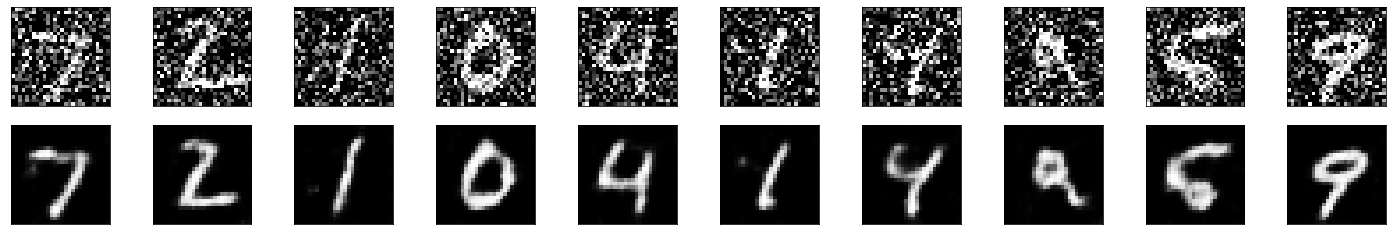

In [32]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = denoiser_model(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

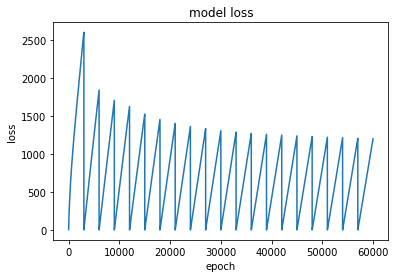

In [33]:
plt.title('model loss')
plt.plot(train_loss2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()